In [1]:
import numpy as np 
import math
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();
from numpy.linalg import norm
from scipy.linalg import svd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
nlp = spacy.load('en_core_web_sm')  
porter = PorterStemmer()

TypeError: Plain typing.NoReturn is not valid as type argument

**In the first part of the project, the dataset is analyzed. There are two tables, one containing the texts and the information about the songs, the other containing information about the artists. The tables are linked by the artist-link and can be merged by a join. 
It is possible to visualize the most common words of the songs by a wordcloud. 
After that, the texts of the songs are cleaned, removing stop words and punctuation and performing stemming.**

In [2]:
#Load the dataset and remove rows containing null values
data = pd.read_csv('lyrics-data.csv')
artists = pd.read_csv('artists-data.csv')
data.dropna(inplace=True)

In [3]:
#Keep only one song for each artist
only_one_per_author = True
#Keep only one genre for each artist (to have a link between a song and a genre)
only_one_genre_per_author = True
#Avoid duplicates between titles, in order to retrive a unique song by its title
only_one_song_per_title = True
#Load the term document matrix instead of generating it
load_termdocMatrix = True

if only_one_per_author:
    data = data.drop_duplicates(subset=['ALink'], keep='first')
if only_one_genre_per_author:
    artists = artists.drop_duplicates(subset=['Link'], keep='first')
if only_one_song_per_title:
    data = data.drop_duplicates(subset=['SName'], keep='first')

#Keep only the songs in english    
data = data.drop(data[data['Idiom'] != 'ENGLISH'].index)
data.shape

#The two tables are merged
dataAll = pd.merge(left=data, right=artists, left_on='ALink', right_on='Link')
dataAll.head(10)

,ALink,SName,SLink,Lyric,Idiom,Artist,Songs,Popularity,Link,Genre,Genres
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,/12-stones/,World So Cold,/12-stones/world-so-cold.html,"It starts with pain, followed by hate. Fueled ...",ENGLISH,12 Stones,75,0.3,/12-stones/,Rock,Rock; Gospel/Religioso; Hard Rock; Grunge; Roc...
2,/3-doors-down/,Here Without You,/3-doors-down/here-without-you.html,"A hundred days have made me older,. Since the ...",ENGLISH,3 Doors Down,91,4.9,/3-doors-down/,Rock,Romântico; Rock; Rock Alternativo; Pop/Rock; T...
3,/311/,Love Song,/311/love-song.html,Whenever I’m alone with you. You make me feel ...,ENGLISH,311,196,0.5,/311/,Rock,Rock; Surf Music; Reggae; Ska; Pop/Rock; Rock ...
4,/4-non-blondes/,What's Up,/4-non-blondes/whats-up.html,Twenty-five years and my life is still. Trying...,ENGLISH,4 Non Blondes,15,7.5,/4-non-blondes/,Rock,Rock; Pop/Rock; Rock Alternativo; Grunge; Blue...
5,/a-day-to-remember/,If It Means A Lot To You,/a-day-to-remember/if-it-means-a-lot-to-you.html,"Hey darling, I hope you're good tonight. And I...",ENGLISH,A Day To Remember,81,0.7,/a-day-to-remember/,Rock,Hardcore; Rock; Pop/Punk; Punk Rock; Rock Alte...
6,/ac-dc/,Back In Black,/ac-dc/back-in-black.html,"Back in black, I hit the sack,. I've been too ...",ENGLISH,AC/DC,192,10.8,/ac-dc/,Rock,Rock; Heavy Metal; Classic Rock; Hard Rock; Cl...
7,/acid-tree/,Adrift,/acid-tree/adrift.html,Among sheets and broken glass. Stale drinks an...,ENGLISH,Acid Tree,5,0.0,/acid-tree/,Rock,Rock; Heavy Metal; Metal
8,/adam-albuquerque/,Good Guys (Feat. Gabriel Carson),/adam-albuquerque/good-guys-feat-gabriel-carso...,"I have the power in my hands. I am brave, I am...",ENGLISH,Adam Albuquerque,1,0.0,/adam-albuquerque/,Rock,Pop/Rock; Rock
9,/adam-lambert/,Whataya Want From Me,/adam-lambert/whataya-want-from-me.html,"Hey, slow it down. What do you want from me. W...",ENGLISH,Adam Lambert,110,1.4,/adam-lambert/,Pop,Pop; Pop/Rock; Rock; Romântico; Dance; Electro...


In [4]:
def get_wordcloud(documents):
    
    """Given a set of texts, plot the wordcoud containing the most common words """
    
    text = "".join(str(c) for c in documents)
    wc = WordCloud(background_color="white", max_words=2000,
                   stopwords=STOPWORDS, max_font_size=100,
                   random_state=42, width=500, height=500)
    wc.generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()


In [5]:
def clean_text(text):
    
    """Given a text, return the same text without words smaller than two letters, numbersd and punctuation. 
    Apply also stemming on the words of the text"""
    
    text = ' '.join([c.lower() for c in str(text).split() if len(c)>2])
    numbers_patterns = re.compile('[0-9]+[\w]*')
    text = re.sub(numbers_patterns, '', text)
    punctiation_pattern = re.compile('[!-_@#$%^''&*()?`<>;\.,:"]')
    text = re.sub(punctiation_pattern, '', text)
    text = ' '.join(porter.stem(word) for word in text.split()) 
    return text

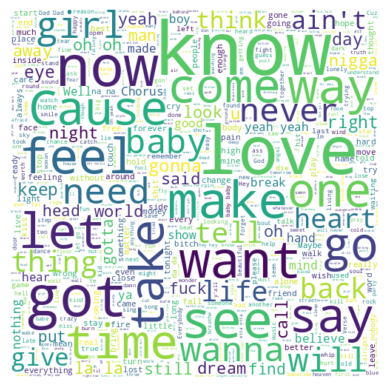

In [6]:
get_wordcloud(dataAll['Lyric'])

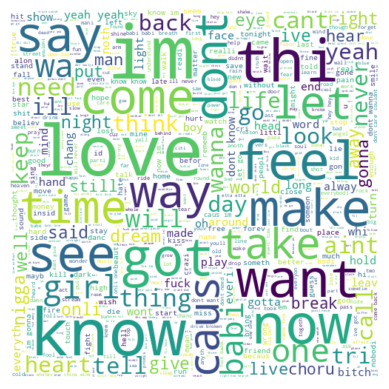

In [7]:
dataAll['Lyric'] = dataAll['Lyric'].apply(clean_text)
get_wordcloud(dataAll['Lyric'])

**From the dataset, it is possible to build a dictionary with all the terms associated to a list of songs that contain that term.**

**From the dictionary, a sparse matrix (called term-document matrix) is created with the songs as columns and the terms as rows. If a term *i* is present in the song *j*, then *M[i,j] = 1* otherwise *M[i,j] = 0***

**This matrix is then updated with the TF-IDF values**

In [8]:
def createDictionaryAndTermDocumentMatrixFreqency(dataAll):
    
    """Given the dataset, build a dictionary (with term - list of documents containing the term) 
    and the term-document matrix"""
    
    dictionary = {}
    for index, row in dataAll.iterrows():
        tokens = [w.lemma_ for w in nlp(row['Lyric'])
                  if not w.is_stop and w.pos_ != 'PUNCT']
        for t in tokens:
            dictionary[t] = dictionary.setdefault(t, [])
            dictionary[t] += [index]
    A = lil_matrix((len(dictionary.keys()), len(dataAll)), dtype=int)
    for i, t in enumerate(dictionary.keys()):
        for j in dictionary[t]:
            A[i, j] = A[i, j]+1
    tdm = pd.DataFrame(A.toarray(), index=dictionary.keys(), columns=dataAll['SName'])
    tdm
    return dictionary, tdm

def updateTermDocumentMatrixTF(tdm):
    
    """Given the term-document matrix, 
     update the values with the term frequency"""
    
    for i in range(tdm.shape[1]): #iterate over cols
        d=0
        for j in range(tdm.shape[0]): #iterate over rows
            d = d + tdm.iloc[j,i]
        
        tdm.iloc[i] = tdm.iloc[i].apply(lambda x: x/float(d))
            
    return tdm

def updateTermDocumentMatrixIDF(tdm):
    
    """Given the term-document matrix with term frequency, 
    update the values multipling them for the inverse document frequency"""
    
    for i in range(tdm.shape[0]): #iterate over rows
        idf=0
        for j in range(tdm.shape[1]): #iterate over cols
            if(tdm.iloc[i,j] > 0):
                idf = idf + 1
        idf = math.log(tdm.shape[1]/float(idf)   , 10)  
        for j1 in range(tdm.shape[1]): #iterate over cols
            tdm.iloc[i,j1] = tdm.iloc[i,j1] * idf
            
    return tdm

In [9]:
if load_termdocMatrix:
    termDocMatrix = pd.read_csv('termDocMatricTFIDF.csv')
    dictionary, tdm = createDictionaryAndTermDocumentMatrixFreqency(dataAll)
else:
    dictionary, termDocMatrix = createDictionaryAndTermDocumentMatrixFreqency(dataAll)
    termDocMatrix = updateTermDocumentMatrixTF(termDocMatrix)
    termDocMatrix.to_csv('termDocMatricTF.csv',index=False)
    termDocMatrix = updateTermDocumentMatrixIDF(termDocMatrix)
    termDocMatrix.to_csv('termDocMatricTFIDF.csv',index=False)

In [10]:
tdm

SName,More Than This,World So Cold,Here Without You,Love Song,What's Up,If It Means A Lot To You,Back In Black,Adrift,Good Guys (Feat. Gabriel Carson),Whataya Want From Me,...,Freak The Freak Out,After You Left,Shut Up and Dance,Fantasy,Hello My Love,Take You Away,Girls Girls,Fairytales,All I Want Is You (Feat. Caelu),Keep It Undercover
feel,1,3,0,6,2,2,0,1,0,0,...,0,3,1,0,0,0,0,1,0,0
time,1,2,4,0,1,0,0,2,0,3,...,0,6,0,2,4,17,0,0,0,0
wa,3,0,0,0,1,0,0,2,0,0,...,0,0,0,2,0,0,0,0,0,0
way,4,1,1,0,0,0,1,0,0,0,...,0,8,0,6,2,0,0,0,0,2
know,7,0,1,0,1,5,0,0,0,0,...,4,3,4,1,9,0,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tickl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
alert,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
fearless,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
kepp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
termDocMatrix

,More Than This,World So Cold,Here Without You,Love Song,What's Up,If It Means A Lot To You,Back In Black,Adrift,Good Guys (Feat. Gabriel Carson),Whataya Want From Me,...,Freak The Freak Out,After You Left,Shut Up and Dance,Fantasy,Hello My Love,Take You Away,Girls Girls,Fairytales,All I Want Is You (Feat. Caelu),Keep It Undercover
0,0.005575,0.016724,0.000000,0.033448,0.011149,0.011149,0.000000,0.005575,0.0,0.000000,...,0.000000,0.016724,0.005575,0.000000,0.000000,0.00000,0.000000,0.005575,0.0,0.000000
1,0.002724,0.005448,0.010897,0.000000,0.002724,0.000000,0.000000,0.005448,0.0,0.008172,...,0.000000,0.016345,0.000000,0.005448,0.010897,0.04631,0.000000,0.000000,0.0,0.000000
2,0.017137,0.000000,0.000000,0.000000,0.005712,0.000000,0.000000,0.011424,0.0,0.000000,...,0.000000,0.000000,0.000000,0.011424,0.000000,0.00000,0.000000,0.000000,0.0,0.000000
3,0.034292,0.008573,0.008573,0.000000,0.000000,0.000000,0.008573,0.000000,0.0,0.000000,...,0.000000,0.068583,0.000000,0.051437,0.017146,0.00000,0.000000,0.000000,0.0,0.017146
4,0.013684,0.000000,0.001955,0.000000,0.001955,0.009774,0.000000,0.000000,0.0,0.000000,...,0.007819,0.005865,0.007819,0.001955,0.017594,0.00000,0.001955,0.000000,0.0,0.009774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.952308,0.0,0.000000
8417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,8.856924
8418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,8.856924
8419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,2.952308


**Using the term-document matrix it is possible to compute a low-rank approximation (rank k), thanks to the singular value decomposition. Three matrices are obtained:**
* **u term-concept matrix**
* **s concept matrix**
* **v document-concept**

**These matrices can be used as a representation of the documents in term of concepts (pseudo-terms) for comparing different documents. Also a query can be represented in the space of concept in order to get the cosine similarity with each document.**

In [12]:
def singularValueDecomposition(termDocMatrix, k, dictionary, dataAll):
    
    """Given the term-document matrix, the number of pseudp-terms, the dictionary and the dataset, 
    compute the singular value decomposition"""
    
    u, s, vt = svd(termDocMatrix)                              
    VT = vt[:k, :]
    df_vt = pd.DataFrame(VT, columns=dataAll['SName'])
    US = u[:, :k] @ np.diag(s[:k])
    df_us = pd.DataFrame(US, index=dictionary.keys())
    return US, df_vt, df_us

def retrieve(query, W, Vt):

    """Given a free text, retrieve the documents
    relevant to the query. """
    
    query = clean_text(query)
    querytokns = [w.lemma_ for w in nlp(query)
              if not w.is_stop and w.pos_ != 'PUNCT']
    q = W.loc[querytokns, :].mean(axis=0)
    nrm = norm(q)
    q /= nrm
    sim = list()
    i = 0
    for column in df_vt:
        sim.append((i , q.dot(df_vt.iloc[:,i])/norm(q) / norm(df_vt.iloc[:,i]), Vt.columns[i] ))
        i = i+1
    sim.sort(key=lambda x:x[1], reverse=True)
    
    return sim

In [13]:
k = 50
US, df_vt, df_us = singularValueDecomposition(termDocMatrix, k, dictionary, dataAll)

In [14]:
df_us.head(100)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
feel,-0.043882,0.001291,-0.008901,0.008845,-0.000954,0.036536,0.002173,0.016828,-0.067417,0.028749,...,0.013642,-0.018172,-0.003151,-0.030406,-0.006687,-0.000728,-0.032631,-0.077606,0.045144,-0.037672
time,-0.013349,0.003463,-0.001546,0.006667,-0.000518,0.011856,-0.002032,0.007024,-0.000559,0.001306,...,0.000068,-0.002309,0.008985,-0.005246,0.000700,0.003737,0.006704,-0.009413,-0.000844,-0.012881
wa,-0.021321,0.007183,-0.003739,0.020322,-0.006673,0.033191,-0.000335,0.015261,-0.000858,0.005485,...,0.001198,-0.012485,-0.004862,0.002236,0.001630,0.006954,0.007491,-0.011438,-0.002392,-0.028777
way,-0.071989,0.002003,-0.020670,0.002587,-0.010222,0.047632,-0.004146,0.010599,-0.009252,0.005845,...,0.002648,-0.026406,-0.003467,-0.026803,0.002901,0.018634,0.024256,-0.031915,-0.012316,-0.031367
know,-0.019383,0.002823,-0.012307,0.006690,-0.003217,0.044050,-0.002749,0.020577,-0.006128,0.004547,...,0.007034,-0.012708,0.001752,-0.034392,-0.007575,-0.037739,-0.011436,-0.003982,0.013402,-0.011108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
separ,-0.000025,0.000008,-0.000027,0.000029,-0.000010,0.000552,0.000054,0.000232,-0.000022,0.000044,...,0.000344,-0.000650,-0.000396,-0.000998,-0.000150,0.000123,0.000887,-0.001147,-0.001876,-0.003200
disappear,-0.000126,0.000462,-0.000125,0.000275,-0.000101,0.002918,-0.000459,0.002138,-0.000059,0.002915,...,-0.000600,0.002988,-0.001978,-0.002319,-0.000089,-0.003296,0.006206,-0.002020,0.002741,0.004998
babi,-0.053782,0.002628,-0.019213,0.008079,-0.004638,0.063067,0.010088,0.017653,-0.084577,0.011130,...,0.107364,-0.004242,-0.074287,-0.058121,0.080011,-0.074409,0.038557,-0.094768,0.135714,0.030469
lone,-0.003969,0.000228,-0.003789,0.005601,-0.000383,0.025124,-0.008704,0.021451,0.000098,-0.008175,...,0.001306,-0.008322,-0.001428,-0.011620,0.003671,-0.011355,0.009129,-0.012679,-0.003788,-0.014551


In [15]:
df_vt.head(10)

SName,More Than This,World So Cold,Here Without You,Love Song,What's Up,If It Means A Lot To You,Back In Black,Adrift,Good Guys (Feat. Gabriel Carson),Whataya Want From Me,...,Freak The Freak Out,After You Left,Shut Up and Dance,Fantasy,Hello My Love,Take You Away,Girls Girls,Fairytales,All I Want Is You (Feat. Caelu),Keep It Undercover
0,-5.094177e-08,-2.924818e-07,-1.869894e-07,-9.551293e-08,-5.402343e-07,-2.980999e-07,-6.118786e-07,-1.384247e-07,-1.656070e-07,-3.326001e-07,...,-0.000301,-0.000014,-0.000208,-0.000307,-0.000023,-0.000006,-0.000046,-0.000040,-1.827990e-07,-0.000036
1,2.126216e-08,1.132248e-07,4.995553e-08,5.298447e-08,2.586069e-07,8.365132e-07,2.480912e-07,2.072404e-08,5.747937e-08,5.693773e-08,...,0.000168,0.000007,0.000611,0.000009,0.000142,0.000003,0.000005,0.000100,6.913422e-07,0.000109
2,-5.159300e-08,-1.621022e-07,-1.261398e-07,-5.374231e-08,-7.272719e-07,-7.788355e-07,-3.973121e-07,-7.061656e-08,-1.753596e-06,-3.719000e-07,...,-0.000493,-0.000019,-0.000037,-0.000027,-0.000054,-0.000002,-0.000079,-0.000013,-1.992437e-06,-0.000084
3,5.858575e-08,2.320101e-07,2.610451e-07,6.201272e-08,2.873763e-06,9.668079e-07,1.147719e-06,9.918986e-08,1.099579e-06,7.889417e-07,...,0.000976,0.000028,0.000093,0.000013,0.000144,0.000003,0.000152,0.000013,1.623621e-06,0.000078
4,-3.163565e-08,-1.389664e-07,-1.855570e-07,-1.223767e-07,-3.185857e-07,-2.698579e-07,-2.127925e-07,-4.953563e-08,-6.701338e-08,-9.057241e-08,...,-0.000808,-0.000016,-0.003480,-0.000008,-0.000019,-0.000002,-0.000154,-0.000127,-6.232069e-07,-0.000026
5,4.746124e-07,2.740538e-06,1.536518e-06,7.415720e-07,1.193468e-05,6.287687e-06,7.355051e-06,1.705189e-06,8.330609e-06,3.088029e-06,...,0.020475,0.000551,0.000818,0.000425,0.001752,0.000172,0.001029,0.000297,6.228693e-05,0.002701
6,-1.014593e-08,-3.500521e-07,-7.623781e-08,3.319733e-09,-4.757142e-07,-1.293146e-06,-3.463399e-07,-3.048727e-07,-2.897204e-06,-6.075406e-09,...,-0.001242,-0.000032,0.000079,-0.000162,0.000046,0.000161,-0.000346,0.000008,-3.182367e-06,0.000719
7,1.307457e-07,1.439168e-06,5.817391e-07,1.480210e-07,8.323500e-06,4.590074e-06,2.702486e-06,6.492833e-08,7.965023e-06,1.531206e-06,...,0.010874,0.000255,0.000365,0.000138,-0.000275,-0.000075,0.001076,0.000124,3.611277e-05,0.000730
8,-9.360488e-08,-3.125597e-07,-8.003856e-07,-1.769925e-07,-7.933261e-07,-5.175663e-07,-4.140403e-07,-2.896005e-07,-2.542845e-07,-5.185586e-07,...,-0.000091,-0.000005,-0.000020,-0.000128,-0.000019,-0.000003,0.000003,-0.000003,-7.145880e-07,-0.000121
9,1.237597e-07,7.560697e-08,4.099239e-07,1.821272e-07,2.139907e-05,3.429423e-08,1.289902e-06,2.466115e-07,-9.252365e-07,6.006499e-07,...,0.008924,0.000100,0.000202,-0.000011,0.000208,0.000009,-0.000282,0.000032,6.055224e-06,0.000264


**Using a rank k = 50 it can be noticed that, considering the full text of a song (in this case 'Back In Black') as the query, the song is not retrieved as the best match. So, different values of k are used to analyze the retrivial and the smallest value of k for which 'Back In Black' is considered the best match is chosen for the model.** 

In [16]:
query1 = "Back in black I hit the sack I've been too long, I'm glad to be back Yes, I'm let loose From the noose that's me hanging about I've been looking at the sky Cause it's gettin me high Forget the hearse cause I never die I got nine lives Cat's eyes Abusin' every one of them and running wild"
sim = retrieve(query1, df_us, df_vt)
sim[:3]

[(6, 0.8140832306989118, 'Back In Black'),
 (649, 0.8107804492806509, '7 Rings'),
 (16, 0.7982429446510476, 'Man In The Box')]

In [17]:
k = 10
US, df_vt, df_us = singularValueDecomposition(termDocMatrix, k, dictionary, dataAll)
sim = retrieve(query1, df_us, df_vt)
sim[:40]

[(21, 0.9831247337211465, 'There Is A Light That Never Goes Out'),
 (301, 0.9771326335584901, 'Forgive Me'),
 (196, 0.9474642137520191, 'Ruby'),
 (22, 0.947327258633125, 'Think Higher'),
 (396, 0.9452618598515998, 'Just Like Honey'),
 (310, 0.941457893053797, "Don't Lose Control"),
 (637, 0.9386132416937624, 'Where Have You Been'),
 (343, 0.9354538860504454, 'Superstar'),
 (9, 0.934044813494123, 'Whataya Want From Me'),
 (416, 0.9335922677088285, 'She Bangs The Drums'),
 (683, 0.9317287384656658, 'Under The Sun'),
 (49, 0.9288385425539434, 'Iron Man'),
 (334, 0.9279028674960357, 'I Remember You'),
 (749, 0.9277440718808535, 'Bottles of Merlot'),
 (844, 0.9266619279518942, 'Better Together'),
 (612, 0.9256266597450943, 'See You Again'),
 (620, 0.9256266597450938, 'See You Again (Feat. Charlie Puth)'),
 (729, 0.9254104869540262, 'Save Me'),
 (464, 0.9251661058390273, 'Amazing (Feat. Joe Welch)'),
 (529, 0.9250786828960237, 'Down (Feat. Lil Wayne)'),
 (661, 0.9246025279370125, 'Jungle Boy

In [18]:
k = 20
US, df_vt, df_us = singularValueDecomposition(termDocMatrix, k, dictionary, dataAll)
sim = retrieve(query1, df_us, df_vt)
sim[:20]

[(21, 0.9129164705827374, 'There Is A Light That Never Goes Out'),
 (629, 0.9075754560042102, 'Byob'),
 (559, 0.9013843707114456, 'Everybody Know Me'),
 (61, 0.8870430254339973, 'Medicine'),
 (213, 0.8865105693976802, "Big Pimpin' / Papercut"),
 (770, 0.8861047332976539, 'Botanic Gardens'),
 (544, 0.8820525623320905, 'Alright'),
 (510, 0.8819394422782627, 'Firm Biz'),
 (236, 0.8797469965515882, 'Kids'),
 (496, 0.8792192524737116, "Ain't It Funny"),
 (469, 0.8791543072725194, 'Fast Lane'),
 (153, 0.8787808559979176, 'Iris'),
 (23, 0.8786780714795663, 'She Is Beautiful'),
 (371, 0.8759748871208263, 'The House Of The Rising Sun'),
 (608, 0.8750418708462467, '2 Minute Warning (Feat. Detail, K-Ci & Jojo)'),
 (779, 0.870787624939009, 'Woman Like Me (Feat. Nicki Minaj)'),
 (495, 0.8698891833265897, 'My Band'),
 (6, 0.8692266802920525, 'Back In Black'),
 (596, 0.8659453066010252, 'Whatever You Like'),
 (109, 0.8655302120590104, 'Save Tonight')]

In [19]:
k = 60
US, df_vt, df_us = singularValueDecomposition(termDocMatrix, k, dictionary, dataAll)
sim = retrieve(query1, df_us, df_vt)
sim[:10]

[(6, 0.7977472414870436, 'Back In Black'),
 (649, 0.757304718472119, '7 Rings'),
 (4, 0.7322914285072633, "What's Up"),
 (16, 0.7136438948091688, 'Man In The Box'),
 (405, 0.7045651100056101, 'Complication'),
 (23, 0.7025772584737865, 'She Is Beautiful'),
 (7, 0.6915958812097569, 'Adrift'),
 (622, 0.6866879562507782, 'Back In The Game'),
 (12, 0.6718058592435637, 'Always A Friend'),
 (0, 0.6710401679901667, 'More Than This')]

**Each concept is represented by the terms and the weight that each term has on that concept. For example, the top 5 terms for concepts 56 and 15 are:**

In [20]:
term1 = df_us.iloc[:,56]
term1 = term1.sort_values(ascending=False)
top_5 = term1[:5]
plt.title('Top terms along the axis of Latent concept 56')
fig = sns.barplot(x=top_5.values, y=top_5.index)

In [21]:
term1 = df_us.iloc[:,15]
term1 = term1.sort_values(ascending=False)
top_5 = term1[:5]
plt.title('Top terms along the axis of Latent concept 56')
fig = sns.barplot(x=top_5.values, y=top_5.index)

**It is also possible to compare different terms by the cosine similarity in the space of concepts. To visualize the terms, two pseudo-terms (the same of the previous barplots) are used as x-axis and y-axis and the terms are scattered**

In [22]:
#Compare two words to get the similarity between terms
love = df_us.loc['love', :].to_numpy()
girl = df_us.loc['girl', :].to_numpy()
pain = df_us.loc['pain', :].to_numpy()
tonight = df_us.loc['tonight', :].to_numpy()
time = df_us.loc['time', :].to_numpy()
babi = df_us.loc['babi', :].to_numpy()
boy = df_us.loc['boy', :].to_numpy()


print("Similarity love and pain = ", love.dot(pain) / norm(love) / norm(pain))
print("Similarity tonight and pain = ", pain.dot(tonight) / norm(pain) / norm(tonight))
print("Similarity love and time = ", love.dot(time) / norm(love) / norm(time))
print("Similarity time and tonight = ", tonight.dot(time) / norm(tonight) / norm(time))
print("Similarity girl and love = ", love.dot(girl) / norm(love) / norm(girl))
print("Similarity girl and babi = ", babi.dot(girl) / norm(babi) / norm(girl))
print("Similarity girl and boy = ", boy.dot(girl) / norm(boy) / norm(girl))

Similarity love and pain =  0.19644893605488373
Similarity tonight and pain =  0.14838967438772888
Similarity love and time =  0.43683591177327585
Similarity time and tonight =  0.43868102254646524
Similarity girl and love =  0.4105736199626055
Similarity girl and babi =  0.4772604466467459
Similarity girl and boy =  0.1643287517549125


In [23]:
#Plot the term vectors projections on two axis (concept 15 and 56)

bye = df_us.loc['bye', :].to_numpy()
bad = df_us.loc['bad', :].to_numpy()
moonlight = df_us.loc['moonlight', :].to_numpy()
tough = df_us.loc['tough', :].to_numpy()
player = df_us.loc['player', :].to_numpy()
dad = df_us.loc['dad', :].to_numpy()
rock = df_us.loc['rock', :].to_numpy()

fig = plt.figure(figsize=(10, 8)); ax = fig.gca()
ax.arrow(0, 0, tough[15], tough[56],       width=0.10, alpha=0.3,color='r')
ax.arrow(0, 0, bad[15], bad[56],       width=0.10, alpha=0.3,color='r')
ax.arrow(0, 0, moonlight[15], moonlight[56], width=0.10, alpha=0.3,color='r')
ax.arrow(0, 0, player[15], player[56], width=0.10, alpha=0.3,color='r')
ax.arrow(0, 0, dad[15], dad[56], width=0.10, alpha=0.3,color='r')
ax.arrow(0, 0, rock[15], rock[56], width=0.10, alpha=0.3,color='r')
ax.scatter(US[: , 15], US[: ,56], alpha=0.5)
ax.scatter(0, 0,  color='r', marker='*', s=150, alpha=0.6);

ax.annotate('bye', (tough[15], tough[56]))
ax.annotate('bad', (bad[15], bad[56]))
ax.annotate('pain', (moonlight[15], moonlight[56]))
ax.annotate('tonight', (player[15], player[56]))
ax.annotate('dad', (dad[15], dad[56]))
ax.annotate('rock', (rock[15], rock[56]))

ax.set_xlim((-3, 12)); ax.set_ylim((-10, 12));
ax.set_title('Term Vectors');


**To compare two documents, the cosine similarity is used:**

In [24]:
#Compare two songs to get the similarity between documents
song1 = df_vt.loc[:, 'More Than This'].to_numpy()
song2    = df_vt.loc[:, 'Back In Black'].to_numpy()
song3    = df_vt.loc[:, 'Fantasy'].to_numpy()

print("Similarity More Than This and Back In Black = ", song1.dot(song2)/(norm(song1)*norm(song2)))
print("Similarity More Than This and Fantasy = ", song1.dot(song3)/(norm(song1)*norm(song3)))
print("Similarity Back In Black and Fantasy = ", song2.dot(song3)/(norm(song2)*norm(song3)))

Similarity More Than This and Back In Black =  0.7354984989513879
Similarity More Than This and Fantasy =  0.4449026805921164
Similarity Back In Black and Fantasy =  0.2923061444895639


**It is possible to have an idea of the quality of the system by executing some queries and deciding if the retrieved documents are relevant or not. The decision is taken reading the lyrics and looking at the key words of the query. The "precision at K" method is used , with K equal to 5.**

In [25]:
query2 = "love heart"
sim2 = retrieve(query2, df_us, df_vt)
sim2[:5]

#Remembering Sunday -> relevant
#Did You Enjoyed The Feeling? -> not relevant
#Love Exists -> relevant
#If It Means A Lot To You -> not relevant
#I Can't Live Without Your Love -> relevant

#precision: 3/5 = 0.6

[(20, 0.8469550093081387, 'Love Exists'),
 (56, 0.8432733268678213, 'Did You Enjoyed The Feeling?'),
 (17, 0.8380965833294783, 'Remembering Sunday'),
 (650, 0.7719661710000949, 'Close To The Edge'),
 (569, 0.7656019805580494, 'Baby Love (feat. will.i.am)')]

In [26]:
query2 = "happy party smile"
sim2 = retrieve(query2, df_us, df_vt)
sim2[:5]

#Try -> relevant
#Party For One -> relevant
#You Can't Get Away From Me -> relevant
#Everybody Know Me -> relevant
#Girls Like You (Feat. Cardi B) -> not relevant

#precision: 4/5 = 0.8

[(789, 0.9105000493954193, 'Try'),
 (673, 0.840740991304949, 'Party For One'),
 (15, 0.754690263667934, 'Poison'),
 (559, 0.7218038266763193, 'Everybody Know Me'),
 (227, 0.7172945461648211, 'Girls Like You (Feat. Cardi B)')]

In [27]:
query2 = "dark night"
sim2 = retrieve(query2, df_us, df_vt)
sim2[:5]

#Whataya Want From Me -> not relevant
#Too Little, Too Late -> relevant
#Don't Break Me Down -> relevant
#More Than This-> relevant
#Hard Times Come Easy -> not relevant

#precision: 3/5 = 0.6

[(579, 0.6666709866262164, 'Bad Poets (feat. N. Dre, Eevo)'),
 (2, 0.663744274892407, 'Here Without You'),
 (751, 0.6251328895048863, 'Too Little, Too Late'),
 (0, 0.6179946632074605, 'More Than This'),
 (233, 0.6136203914096248, 'Down Under')]

In [28]:
query2 = "rock monster bad"
sim2 = retrieve(query2, df_us, df_vt)
sim2[:5]

#I Was A Teenage Werewolf -> relevant
#Drop The Mask-> relevant
#Monster -> relevant
#All Monsters -> relevant
#Burning -> relevant

#precision: 5/5 = 1

[(381, 0.7050472848354529, 'I Was A Teenage Werewolf'),
 (48, 0.6971142112710238, 'Drop The Mask'),
 (335, 0.6893331257222497, 'Monster'),
 (777, 0.688081712624668, 'All Monsters'),
 (226, 0.6020031778538992, 'Burning')]

In [29]:
dataAll['Lyric'][777]

'show the messeg show the pray tri the best how one day new york pray the round from the heel for the other thi save are all monster monster are all monster are all monster are all monster momomonst monster are all monster are all monster are all monster one the choic pleas dont feel were are crack till are pleas and reales all the payment broken rich till are welcom back and see are all monster monster are all monster are all monster are all monster momomonst monster are all monster are all monster are all monster are all monster momomonst are all monster momomonst are all monster monster are all monster are all monster are all monster momomonst monster are all monster are all monster are all monster'

**So precision can be calculated as the average of the queries performed : (0.6 + 0.8 + 0.6 + 1)/4 = 0.75**
